In [16]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import (
    AutoTokenizer,
    CamembertForTokenClassification,
    AdamW,
    DataCollatorForTokenClassification
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import os


In [17]:

############################################################################
# 1) Load the UD French Sequoia dataset
############################################################################

dataset = load_dataset("universal_dependencies", "fr_ftb", trust_remote_code=True) # Switch the name of the dataset:  fr_gsd, fr_partut, fr_sequoia

print("Dataset splits:\n", dataset)  # train, validation, test

Dataset splits:
 DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 14759
    })
    validation: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 1235
    })
    test: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 2541
    })
})


In [3]:
deprel_feature = dataset["train"].features["deprel"]
all_label_strings = deprel_feature.feature

In [5]:
############################################################################
# 2) Inspect the dependency relation (deprel) labels
############################################################################
# Extract all unique labels from the dataset
unique_labels = set()
for split in ["train", "validation", "test"]:
    for example in dataset[split]["deprel"]:
        unique_labels.update(example)

# Create sorted list of labels and mappings
all_label_strings = sorted(list(unique_labels))
num_labels = len(all_label_strings)

id2label = {i: label for i, label in enumerate(all_label_strings)}
label2id = {label: i for i, label in enumerate(all_label_strings)}

print("\nDependency relation labels (string) =>", all_label_strings)
print("Number of distinct deprel labels:", num_labels)



Dependency relation labels (string) => ['_', 'acl', 'acl:relcl', 'advcl', 'advcl:cleft', 'advmod', 'amod', 'appos', 'aux:caus', 'aux:pass', 'aux:tense', 'case', 'cc', 'ccomp:agent', 'ccomp:obj', 'ccomp:obl', 'ccomp:pred', 'conj', 'cop', 'csubj', 'csubj:pass', 'dep', 'dep:comp', 'det', 'discourse', 'dislocated', 'expl:pass', 'expl:subj', 'fixed', 'flat', 'flat:foreign', 'flat:name', 'goeswith', 'iobj', 'iobj:agent', 'mark', 'nmod', 'nsubj', 'nsubj:caus', 'nsubj:pass', 'nummod', 'obj', 'obj:agent', 'obj:lvc', 'obl', 'obl:agent', 'obl:arg', 'obl:mod', 'orphan', 'parataxis', 'punct', 'reparandum', 'root', 'vocative', 'xcomp:obj', 'xcomp:obl', 'xcomp:pred']
Number of distinct deprel labels: 57


In [6]:

############################################################################
# 3) Define the CamemBERT tokenizer
############################################################################
tokenizer = AutoTokenizer.from_pretrained("camembert-base")


In [7]:
def tokenize_and_align_labels(examples):
    """
    Align dependency relation labels (deprel) with tokenized inputs.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True
    )

    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        labels = []
        for word_id in word_ids:
            if word_id is None:
                labels.append(-100)  # special tokens
            else:
                # Map deprel string labels to integer IDs using label2id
                deprel_label = examples["deprel"][i][word_id]
                labels.append(label2id[deprel_label])
        all_labels.append(labels)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


In [8]:

############################################################################
# 5) Apply the function to the dataset
############################################################################
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True
)

Map:   0%|          | 0/1476 [00:00<?, ? examples/s]

In [9]:


############################################################################
# 6) Convert to PyTorch format
############################################################################
tokenized_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

print("\nSample tokenized entry from train set:")
print(tokenized_dataset["train"][0])


Sample tokenized entry from train set:
{'input_ids': tensor([    5,    74,  2177, 12873,    10, 18232,    10,    56,  1758,    86,
        17873,    29,    44,  1382,    46,    11,    91,    19, 11811,  8791,
          838,    79,    13,  9721,    21,     9,     6]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]), 'labels': tensor([-100,   23,   37,   37,   37,    6,    6,   10,   52,    5,   56,   11,
          23,   47,   35,   35,   37,   41,   14,   14,    5,   11,   23,   56,
          50,   50, -100])}


In [10]:


############################################################################
# 7) Define the model, set readable label mappings
############################################################################
model = CamembertForTokenClassification.from_pretrained(
    "camembert-base",
    num_labels=num_labels
)
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:


############################################################################
# 8) Create DataLoaders (batching) for train, validation, and test
############################################################################
train_dataset = tokenized_dataset["train"]
val_dataset   = tokenized_dataset["validation"]
test_dataset  = tokenized_dataset["test"]

batch_size = 32

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True
)

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size,
    collate_fn=data_collator
)


In [12]:
from transformers import get_scheduler
from tqdm import tqdm

############################################################################
# 9) Define optimizer, scheduler, and training settings
############################################################################
learning_rate = 2e-5
num_epochs = 20
optimizer = AdamW(model.parameters(), lr=learning_rate)

# scheduler
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

############################################################################
# 10) Training Loop with validation accuracy
############################################################################
train_losses = []
val_losses = []
val_accuracies = []



/home/amine/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:

for epoch in range(num_epochs):
    # ------------------------- Training -------------------------
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # ------------------------- Validation -------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    for batch in tqdm(val_dataloader, desc="Validating"):
        with torch.no_grad():
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            val_loss += outputs.loss.item()

            logits = outputs.logits
            preds = logits.argmax(dim=-1)
            labels = batch["labels"]

            mask = labels != -100
            val_correct += (preds[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_correct / val_total if val_total > 0 else 0.0

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f}")

Validating: 100%|██████████| 47/47 [00:01<00:00, 27.97it/s]


Epoch 1/5 | Train Loss: 2.5126 | Val Loss: 1.5972 | Val Acc: 0.8778


Validating: 100%|██████████| 47/47 [00:01<00:00, 28.43it/s]


Epoch 2/5 | Train Loss: 1.3557 | Val Loss: 1.0033 | Val Acc: 0.9139


Validating: 100%|██████████| 47/47 [00:01<00:00, 28.23it/s]


Epoch 3/5 | Train Loss: 0.9196 | Val Loss: 0.7234 | Val Acc: 0.9358


Validating: 100%|██████████| 47/47 [00:01<00:00, 28.18it/s]


Epoch 4/5 | Train Loss: 0.7148 | Val Loss: 0.6034 | Val Acc: 0.9416


Validating: 100%|██████████| 47/47 [00:01<00:00, 28.38it/s]

Epoch 5/5 | Train Loss: 0.6316 | Val Loss: 0.5681 | Val Acc: 0.9441


In [ ]:
print(label_counts)
print(label2id)


In [14]:


############################################################################
# 11) Evaluate on Test Set
############################################################################
model.eval()
test_loss = 0.0
test_correct = 0
test_total   = 0

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        test_loss += outputs.loss.item()

        logits = outputs.logits
        preds = logits.argmax(dim=-1)
        labels = batch["labels"]

        mask = labels != -100
        test_correct += (preds[mask] == labels[mask]).sum().item()
        test_total   += mask.sum().item()

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = test_correct / test_total if test_total > 0 else 0.0

print(f"\nFinal Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")



Final Test Loss: 0.6497 | Test Accuracy: 0.9259


In [31]:

############################################################################
# 12) Save the Model + Tokenizer
############################################################################
save_directory = "./my_camembert_deprel_model_partut"
os.makedirs(save_directory, exist_ok=True)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"\nModel and tokenizer saved to: {save_directory}")



Model and tokenizer saved to: ./my_camembert_deprel_model_partut


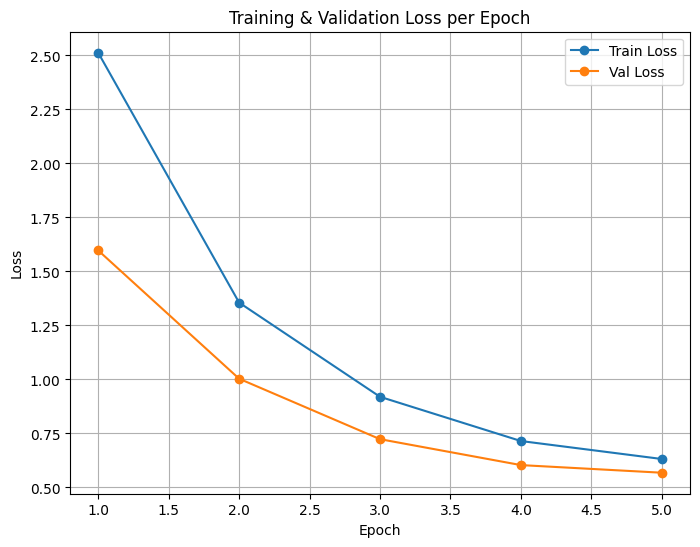

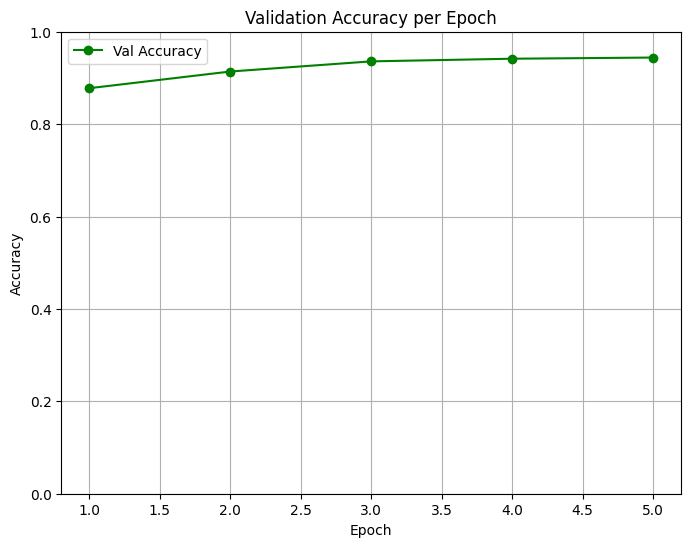

In [15]:

############################################################################
# 13) Plot Training & Validation Loss
############################################################################
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses,   label='Val Loss', marker='o')
plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot_gsd.png")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, val_accuracies, label='Val Accuracy', marker='o', color='green')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.grid(True)
plt.legend()
plt.savefig("accuracy_plot_gsd.png")
plt.show()
